Week 7 Notebook: Optimizing Other Objectives
===============================================================

This week, we will look at optimizing multiple objectives simultaneously. In particular, we will look at pivoting with adversarial neural networks {cite}`Louppe:2016ylz,ganin2014unsupervised,Sirunyan:2019nfw`.

In [1]:
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

Using TensorFlow backend.


In [2]:
# 48 track-level features
features = ['track_pt',
            'track_ptrel',
            'trackBTag_Eta',
            'trackBTag_DeltaR',
            'trackBTag_EtaRel',
            'trackBTag_JetDistVal',
            'trackBTag_Momentum',
            'trackBTag_PPar',
            'trackBTag_PParRatio',
            'trackBTag_PtRatio',
            'trackBTag_PtRel',
            'trackBTag_Sip2dSig',
            'trackBTag_Sip2dVal',
            'trackBTag_Sip3dSig',
            'trackBTag_Sip3dVal',
            'track_VTX_ass',
            'track_charge',
            'track_deltaR',
            'track_detadeta',
            'track_dlambdadz',
            'track_dlambdadz',
            'track_dphidphi',
            'track_dphidxy',
            'track_dptdpt',
            'track_drminsv',
            'track_drsubjet1',
            'track_drsubjet2',
            'track_dxy',
            'track_dxydxy',
            'track_dxydz',
            'track_dxysig',
            'track_dz',
            'track_dzdz',        
            'track_dzsig',
            'track_erel',
            'track_etarel',
            'track_fromPV',
            'track_isChargedHad',
            'track_isEl',
            'track_isMu',
            'track_lostInnerHits',
            'track_mass',
            'track_normchi2',            
            'track_phirel',
            'track_pt',
            'track_ptrel',
            'track_puppiw',
            'track_quality']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb (we'll reduce the following labels)
labels =  ['label_QCD_b',
           'label_QCD_bb',
           'label_QCD_c', 
           'label_QCD_cc', 
           'label_QCD_others',
           'sample_isQCD',
           'label_H_bb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = 2

# we're going to zero-pad up to 60 tracks
ntracks = 60

In [3]:
from DataGenerator import DataGenerator

## Define Gradient Reversal Layer
Here, we define a gradient reversal layer

In [4]:
import tensorflow as tf
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(keras.layers.Layer):
    def __init__(self, name='GradReverse'):
        super().__init__(name=name)

    def call(self, x):
        return grad_reverse(x)

## Define Combined Model with Adversarial Neural Network

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda, Concatenate
import keras.backend as K

# define Deep Sets model with Conv1D Keras layer
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv1D(64, 1, strides=1, padding='same', name = 'conv1d_1', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_2', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_3', activation='relu')(x)
# sum over tracks
x = Lambda(lambda x: K.mean(x, axis=-2), name = 'lambda_1', input_shape=(ntracks,32))(x)
x = Dense(100, name = 'dense_1', activation='relu')(x)
output = Dense(nlabels, name = 'output', activation='softmax')(x)
 
# start adversarial part
input_reg = Concatenate(name='concat_1')([x, output])
x = GradReverse(name='reverse_1')(input_reg)
x = Dense(100, name='dense_2', activation ='relu')(x)
x = Dense(100, name= 'dense_3',activation='relu')(x)
output_reg = Dense(2, activation='linear', name='mass_pt_reg')(x)
#outputs = Concatenate(name='concat_2')([output_reg, output])
                                                            

keras_model_adv = Model(inputs=inputs, outputs=[output, output_reg])
keras_model_adv.compile(optimizer='adam', 
                        loss=['categorical_crossentropy', 'mse'], 
                        loss_weights = [1,1])
print(keras_model_adv.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 60, 48)       0                                            
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 60, 48)       192         input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       3136        bn_1[0][0]                       
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 32)       2080        conv1d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
# load training and validation generators 
train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
val_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=5000,
                                return_spectators=True, scale_mass_pt=[100.,1000.])

val_generator = DataGenerator(val_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                              remove_mass_pt_window=False, 
                              remove_unlabeled=True, max_entry=5000, 
                              return_spectators=True, scale_mass_pt=[100.,1000.])

In [14]:
# define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('keras_model_adv_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [model_checkpoint]

# fit keras model
history_adv = keras_model_adv.fit(train_generator, 
                                  validation_data = val_generator, 
                                  steps_per_epoch=len(train_generator), 
                                  validation_steps=len(val_generator),
                                  max_queue_size=5,
                                  epochs=100, 
                                  shuffle=False,
                                  callbacks = callbacks, 
                                  verbose=1)
# reload best weights
keras_model_adv.load_weights('keras_model_adv_best.h5')

Epoch 1/100
4/4 [==============================] - 3s 675ms/step - loss: 3.4473 - output_loss: 1.0526 - mass_pt_reg_loss: 2394590.0000 - val_loss: 2.4703 - val_output_loss: 1.0977 - val_mass_pt_reg_loss: 1131791.0000
Epoch 2/100
4/4 [==============================] - 2s 607ms/step - loss: 3.4213 - output_loss: 1.0453 - mass_pt_reg_loss: 2375879.0000 - val_loss: 2.4404 - val_output_loss: 1.0759 - val_mass_pt_reg_loss: 1127022.3750
Epoch 3/100
4/4 [==============================] - 2s 623ms/step - loss: 3.3943 - output_loss: 1.0376 - mass_pt_reg_loss: 2356625.2500 - val_loss: 2.4125 - val_output_loss: 1.0556 - val_mass_pt_reg_loss: 1122725.7500
Epoch 4/100
4/4 [==============================] - 2s 613ms/step - loss: 3.3697 - output_loss: 1.0311 - mass_pt_reg_loss: 2338500.0000 - val_loss: 2.3878 - val_output_loss: 1.0376 - val_mass_pt_reg_loss: 1119223.6250
Epoch 5/100
4/4 [==============================] - 2s 622ms/step - loss: 3.3471 - output_loss: 1.0256 - mass_pt_reg_loss: 2321398.50

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 3s 700ms/step - loss: 3.1047 - output_loss: 0.9616 - mass_pt_reg_loss: 2142969.0000 - val_loss: 2.1410 - val_output_loss: 0.8703 - val_mass_pt_reg_loss: 1085920.7500
Epoch 16/100
4/4 [==============================] - 3s 652ms/step - loss: 3.0830 - output_loss: 0.9564 - mass_pt_reg_loss: 2126475.7500 - val_loss: 2.1241 - val_output_loss: 0.8592 - val_mass_pt_reg_loss: 1083975.5000
Epoch 17/100
4/4 [==============================] - 2s 598ms/step - loss: 3.0606 - output_loss: 0.9508 - mass_pt_reg_loss: 2109688.2500 - val_loss: 2.1071 - val_output_loss: 0.8482 - val_mass_pt_reg_loss: 1081937.7500
Epoch 18/100
4/4 [==============================] - 3s 634ms/step - loss: 3.0381 - output_loss: 0.9452 - mass_pt_reg_loss: 2092843.8750 - val_loss: 2.0904 - val_output_loss: 0.8375 - val_mass_pt_reg_loss: 1079957.1250
Epoch 19/100
4/4 [==============================] - 3s 678ms/step - loss: 3.0154 - output_loss: 0.9394 - mass_pt_reg_loss: 2075935.8750 - val

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


2/4 [==============>...............] - ETA: 1s - loss: 2.8800 - output_loss: 0.9691 - mass_pt_reg_loss: 1910816.0000

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3/4 [=====================>........] - ETA: 0s - loss: 2.9465 - output_loss: 0.9519 - mass_pt_reg_loss: 1994619.3750

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 2s 595ms/step - loss: 2.9178 - output_loss: 0.9125 - mass_pt_reg_loss: 2005200.7500 - val_loss: 2.0029 - val_output_loss: 0.7838 - val_mass_pt_reg_loss: 1068134.7500
Epoch 24/100
4/4 [==============================] - 3s 646ms/step - loss: 2.8908 - output_loss: 0.9044 - mass_pt_reg_loss: 1986353.3750 - val_loss: 1.9839 - val_output_loss: 0.7726 - val_mass_pt_reg_loss: 1065223.8750
Epoch 25/100
4/4 [==============================] - 3s 648ms/step - loss: 2.8634 - output_loss: 0.8959 - mass_pt_reg_loss: 1967335.3750 - val_loss: 1.9649 - val_output_loss: 0.7616 - val_mass_pt_reg_loss: 1062268.1250
Epoch 26/100
4/4 [==============================] - 3s 663ms/step - loss: 2.8359 - output_loss: 0.8874 - mass_pt_reg_loss: 1948375.2500 - val_loss: 1.9466 - val_output_loss: 0.7512 - val_mass_pt_reg_loss: 1059417.0000
Epoch 27/100
4/4 [==============================] - 2s 601ms/step - loss: 2.8094 - output_loss: 0.8794 - mass_pt_reg_loss: 1929926.0000 - val

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 3s 678ms/step - loss: 2.5888 - output_loss: 0.8135 - mass_pt_reg_loss: 1775229.1250 - val_loss: 1.7963 - val_output_loss: 0.6710 - val_mass_pt_reg_loss: 1035391.1875
Epoch 37/100
4/4 [==============================] - 3s 670ms/step - loss: 2.5652 - output_loss: 0.8064 - mass_pt_reg_loss: 1758771.0000 - val_loss: 1.7834 - val_output_loss: 0.6645 - val_mass_pt_reg_loss: 1033187.5000
Epoch 38/100
4/4 [==============================] - 3s 648ms/step - loss: 2.5425 - output_loss: 0.7997 - mass_pt_reg_loss: 1742766.2500 - val_loss: 1.7712 - val_output_loss: 0.6585 - val_mass_pt_reg_loss: 1031122.0625
Epoch 39/100
4/4 [==============================] - 3s 637ms/step - loss: 2.5203 - output_loss: 0.7931 - mass_pt_reg_loss: 1727038.5000 - val_loss: 1.7590 - val_output_loss: 0.6526 - val_mass_pt_reg_loss: 1029001.5625
Epoch 40/100
4/4 [==============================] - 3s 649ms/step - loss: 2.4974 - output_loss: 0.7863 - mass_pt_reg_loss: 1711087.0000 - val

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 3s 757ms/step - loss: 2.4305 - output_loss: 0.7661 - mass_pt_reg_loss: 1664323.8750 - val_loss: 1.7121 - val_output_loss: 0.6302 - val_mass_pt_reg_loss: 1020389.6250
Epoch 44/100
4/4 [==============================] - 3s 649ms/step - loss: 2.4080 - output_loss: 0.7592 - mass_pt_reg_loss: 1648740.2500 - val_loss: 1.6999 - val_output_loss: 0.6245 - val_mass_pt_reg_loss: 1017936.7500
Epoch 45/100
4/4 [==============================] - 2s 595ms/step - loss: 2.3845 - output_loss: 0.7516 - mass_pt_reg_loss: 1632766.5000 - val_loss: 1.6874 - val_output_loss: 0.6187 - val_mass_pt_reg_loss: 1015276.0625
Epoch 46/100
4/4 [==============================] - 3s 751ms/step - loss: 2.3603 - output_loss: 0.7437 - mass_pt_reg_loss: 1616547.3750 - val_loss: 1.6747 - val_output_loss: 0.6128 - val_mass_pt_reg_loss: 1012465.0000
Epoch 47/100
4/4 [==============================] - 2s 581ms/step - loss: 2.3362 - output_loss: 0.7357 - mass_pt_reg_loss: 1600389.7500 - val

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 3s 626ms/step - loss: 2.2905 - output_loss: 0.7209 - mass_pt_reg_loss: 1569554.2500 - val_loss: 1.6409 - val_output_loss: 0.5973 - val_mass_pt_reg_loss: 1004920.1250
Epoch 50/100
4/4 [==============================] - 3s 629ms/step - loss: 2.2697 - output_loss: 0.7144 - mass_pt_reg_loss: 1555160.6250 - val_loss: 1.6318 - val_output_loss: 0.5931 - val_mass_pt_reg_loss: 1003038.6250
Epoch 51/100
4/4 [==============================] - 2s 624ms/step - loss: 2.2506 - output_loss: 0.7089 - mass_pt_reg_loss: 1541728.6250 - val_loss: 1.6239 - val_output_loss: 0.5894 - val_mass_pt_reg_loss: 1001531.1875
Epoch 52/100
4/4 [==============================] - 2s 570ms/step - loss: 2.2330 - output_loss: 0.7039 - mass_pt_reg_loss: 1529028.1250 - val_loss: 1.6166 - val_output_loss: 0.5860 - val_mass_pt_reg_loss: 1000191.7500
Epoch 53/100
4/4 [==============================] - 3s 651ms/step - loss: 2.2159 - output_loss: 0.6992 - mass_pt_reg_loss: 1516653.2500 - val

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4/4 [==============================] - 2s 603ms/step - loss: 2.0700 - output_loss: 0.6548 - mass_pt_reg_loss: 1415185.0000 - val_loss: 1.5442 - val_output_loss: 0.5523 - val_mass_pt_reg_loss: 983438.5000
Epoch 62/100
4/4 [==============================] - 3s 668ms/step - loss: 2.0522 - output_loss: 0.6492 - mass_pt_reg_loss: 1402917.3750 - val_loss: 1.5363 - val_output_loss: 0.5486 - val_mass_pt_reg_loss: 981398.6875
Epoch 63/100
4/4 [==============================] - 3s 686ms/step - loss: 2.0345 - output_loss: 0.6436 - mass_pt_reg_loss: 1390798.3750 - val_loss: 1.5285 - val_output_loss: 0.5450 - val_mass_pt_reg_loss: 979317.5625
Epoch 64/100
4/4 [==============================] - 3s 630ms/step - loss: 2.0167 - output_loss: 0.6380 - mass_pt_reg_loss: 1378710.2500 - val_loss: 1.5204 - val_output_loss: 0.5412 - val_mass_pt_reg_loss: 977059.8750
Epoch 65/100
4/4 [==============================] - 3s 657ms/step - loss: 1.9986 - output_loss: 0.6320 - mass_pt_reg_loss: 1366486.6250 - val_los

Epoch 99/100
4/4 [==============================] - 2s 602ms/step - loss: 1.5710 - output_loss: 0.5022 - mass_pt_reg_loss: 1068845.3750 - val_loss: 1.3590 - val_output_loss: 0.4691 - val_mass_pt_reg_loss: 910382.3125
Epoch 100/100
4/4 [==============================] - 3s 643ms/step - loss: 1.5617 - output_loss: 0.4993 - mass_pt_reg_loss: 1062323.7500 - val_loss: 1.3557 - val_output_loss: 0.4679 - val_mass_pt_reg_loss: 908142.3750


In [15]:
# load testing file
test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root'
             ]
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=8192, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True,
                               return_spectators=True,
                               max_entry = 200000) # basically, no maximum

In [18]:
import tqdm
# run model inference on test data set
predict_array_adv = []
label_array_test = []
spec_array_test = []

for t in tqdm.tqdm(test_generator,total=len(test_generator)):
    label_array_test.append(t[1][0])
    spec_array_test.append(t[1][1])
    predict_array_adv.append(keras_model_adv.predict(t[0])[0])
predict_array_adv = np.concatenate(predict_array_adv,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)
spec_array_test = np.concatenate(spec_array_test,axis=0)

100%|██████████| 24/24 [02:57<00:00,  7.38s/it]


(61968, 2)
(61968, 2)
(61968, 2)


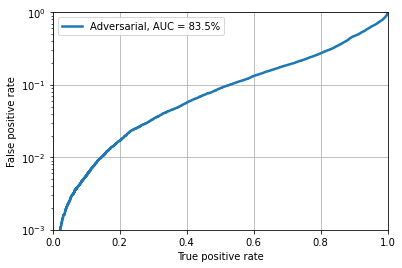

In [22]:
# create ROC curves
print(label_array_test.shape)
print(spec_array_test.shape)
print(predict_array_adv.shape)
fpr_adv, tpr_adv, threshold_adv = roc_curve(label_array_test[:,1], predict_array_adv[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_adv, fpr_adv, lw=2.5, label="Adversarial, AUC = {:.1f}%".format(auc(fpr_adv,tpr_adv)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [23]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

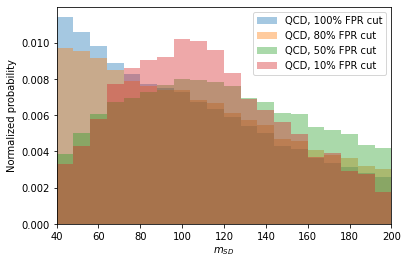

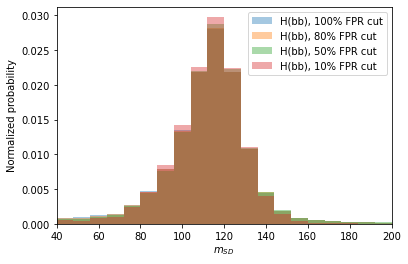

In [28]:
plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,0]*(predict_array_adv[:,1] > threshold_adv[idx]),
             alpha=0.4,density=True, label='QCD, {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)

plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,1]*(predict_array_adv[:,1] > threshold_adv[idx]),
             alpha=0.4,density=True, label='H(bb), {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)
plt.show()